考虑 ATR10 / ATR60. 因为与短期高点有显著正相关。

last_top，原因同上

使用斯皮尔曼相关系数

In [1]:
from analysis_utils import *
from utils import date_to_milliseconds
pd.set_option('display.max_columns', None)

<Figure size 1000x500 with 0 Axes>

In [16]:
usd_name = 'BUSD'
token_name='BTC'
symbol = token_name + usd_name
sim_data = get_combined_data(symbol, '+-0_5Atr60', 1641906420000, 1658229059999)
sim_data_info = read_data(symbol, '+-0_5Atr60', 1641906420000, 1658229059999)
print(f"data length = {len(sim_data)}")

buy_p    = sim_data_info.buy_points
sell_p   = sim_data_info.sell_points

sim_data['buy_price'] = np.nan
sim_data['sell_price'] = np.nan

j = 0
for i in range(len(sim_data)):
    if sim_data['open_time'][i] == buy_p.idx[j]:
        # Record these info on the preview step of the actually traded step
        idx = sim_data.index[i]-1
        sim_data.loc[idx, 'buy_price'] = buy_p.value[j]
        sim_data.loc[idx, 'hold_step'] = (sell_p.idx[j] - buy_p.idx[j]) // 60000
        sim_data.loc[idx, 'sell_price'] = sell_p.value[j]
        sim_data.loc[idx, 'earn'] = (sell_p.value[j] - buy_p.value[j]) / buy_p.value[j]
        
        j += 1
        if j >= len(sell_p.idx):
            break

# sim_data[sim_data['buy_price'].isnull() == False].head()

data length = 272044


In [17]:
total_num = sum(sim_data['buy_price'].isnull() == False)
print(f"Total: {total_num}")
earn_num = sum(sim_data['earn'] > 0)
print(f"Earn rate: {earn_num / total_num * 100 :.2f}%")
print(f"Average earn: {sim_data[sim_data['buy_price'].isnull() == False]['earn'].mean() * 100 :.4f}%")
# 0.5 Atr60
# Total: 1708
# Earn rate: 78.22%
# Average earn: 0.0467%

# 0.5 Atr10
# Total: 1708
# Earn rate: 79.98%
# Average earn: 0.0441%

# 2 Aer10
# Total: 1600
# Earn rate: 77.88%
# Average earn: 0.0158%

Total: 1708
Earn rate: 78.22%
Average earn: 0.0200%


In [3]:
target = Target(target_step=10, steps=[10])
full_data = FeatData(sim_data, target)

# Drop useless features
full_data.drop_features(
   ['close_time', 'volume', 'taker_buy_volume', 'open_time', 'buy_price', 'sell_price'])

full_data.set_features_type(['hold_step'], FeatTypes.OTHERS)
full_data.set_features_type(['earn'], FeatTypes.TARGET)
full_data.add_feature('is_earn', FeatTypes.TARGET, lambda df: df['earn'].apply(lambda x: 1 if x > 0 else 0))
full_data.add_feature('max_after_top', FeatTypes.TARGET, lambda df: 
                      (df['high'].rolling(2).max().shift(-2) - df['last_top']) / df['close'])

full_data.add_feature('TR', FeatTypes.TR, lambda df: df['high'] - df['low'] + 0.001)   # Incase TR is 0
full_data.add_feature('ER', FeatTypes.TR, lambda df: df['close'] - df['open'])

full_data.add_feature('lastlast_top', FeatTypes.PRICE, lambda df: df['last_top'].shift(1))

def add_ll_bottom(df: pd.DataFrame):
   col = df['last_bottom'].shift(1)
   down_idx = df[df['is_up'] == 0].index
   col.loc[down_idx] = df['last_bottom']
   return col

full_data.add_feature('lastlast_bottom', FeatTypes.PRICE, lambda df: add_ll_bottom(df))

# 单位波动的成交额
full_data.add_feature('volume/TR', FeatTypes.VOL_TR, lambda df: df['quote_assert_volume'] * df['close'] / df['TR'])
full_data.drop_features(['quote_assert_volume', 'taker_buy_quote_asset_volume'])

# Add features
add_ave_features(full_data, cycles = [10, 60, 300], feat_names=['close', 'TR', 'volume/TR'])
add_ave_features(full_data, cycles = [10, 60, 300], feat_names=['ER'], new_ave_of_base={'AER': ['ER', FeatTypes.TR]})

fast_period = 10 
slow_period = 60
signal_period = 30
# add_macd(full_data, 'close', FeatTypes.DPRICE, fast_period, slow_period, signal_period)
# add_macd(full_data, 'TR', FeatTypes.TR, fast_period, slow_period, signal_period)

# Standardization
full_data.std()

# Drop na at last
full_data.drop_na()

full_data.df.head()

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_10,is_earn,max_after_top,ER,lastlast_top,lastlast_bottom,MA10,MA60,MA300,ATR10,ATR60,ATR300,AVT10,AVT60,AVT300,AER10,AER60,AER300
312,0.999838,1.000056,0.998913,0.001143,1.000146,36.0,0.992381,56.0,0.0,20.0,0.0,0.000811,0.001583,1,0.001350,0.000162,1.000146,0.992381,0.997541,0.997487,0.987523,0.001225,0.001622,0.001654,0.593612,0.910740,1.004337,0.000345,-0.000096,0.000057
404,1.000224,1.000436,0.999748,0.000688,1.000758,64.0,0.988067,106.0,0.0,42.0,0.0,0.000473,0.002681,1,0.004034,-0.000224,1.000758,0.988067,0.999246,0.997159,0.989377,0.000871,0.000946,0.001579,0.836712,0.793304,1.172480,0.000146,0.000025,0.000092
581,0.998862,1.000000,0.998862,0.001138,1.001052,70.0,0.998672,78.0,0.0,8.0,0.0,0.000220,0.000035,1,0.000445,0.001138,1.001052,0.998672,0.999033,0.999194,1.000433,0.000228,0.000441,0.000846,5.347997,1.848135,1.293108,0.000088,0.000010,0.000024
665,0.999088,1.000236,0.999085,0.001150,1.000362,60.0,0.994068,107.0,0.0,47.0,0.0,0.000352,-0.002023,1,0.001444,0.000912,1.000362,0.994068,0.999123,0.997837,0.997590,0.000955,0.000704,0.000734,2.110453,2.429820,2.967390,0.000130,0.000010,0.000018
781,0.999712,1.000000,0.999667,0.000333,1.000237,33.0,0.997085,49.0,0.0,16.0,1.0,-0.000265,-0.001071,0,0.000049,0.000288,1.000237,0.997085,0.999067,0.998590,1.000377,0.000433,0.000531,0.000605,1.473388,1.174887,1.794641,0.000148,-0.000018,-0.000008


In [5]:
price_feats  = set(full_data.cols_of_features([FeatTypes.PRICE]))
dprice_feats = set(full_data.cols_of_features([FeatTypes.DPRICE]))
tr_feats     = set(full_data.cols_of_features([FeatTypes.TR]))
vol_feats    = set(full_data.cols_of_features([FeatTypes.VOLUME]))
voltr_feats  = set(full_data.cols_of_features([FeatTypes.VOL_TR]))
tn_feats     = set(full_data.cols_of_features([FeatTypes.TRADE_NUM]))
print(f"price_feats: {price_feats}\n\
        dprice_feats: {dprice_feats}\n\
        tr_feats: {tr_feats}\n\
        vol_feats: {vol_feats}\n\
        voltr_feats: {voltr_feats}\n\
        tn_feats: {tn_feats}")
print(f"{set(full_data.df.columns) - price_feats - dprice_feats - tr_feats - vol_feats - tn_feats}")

price_feats: {'low', 'last_top', 'open', 'MA300', 'last_bottom', 'high', 'MA60', 'lastlast_top', 'MA10', 'lastlast_bottom'}
        dprice_feats: set()
        tr_feats: {'AER300', 'TR', 'AER60', 'ER', 'ATR10', 'ATR300', 'AER10', 'ATR60'}
        vol_feats: set()
        voltr_feats: {'AVT10', 'AVT300', 'AVT60'}
        tn_feats: set()
{'AVT10', 'AVT300', 'is_earn', 'earn', 'is_up', 'max_after_top', 'cycle_step', 'step_after_bottom', 'earn_after_10', 'step_after_top', 'hold_step', 'AVT60'}


161


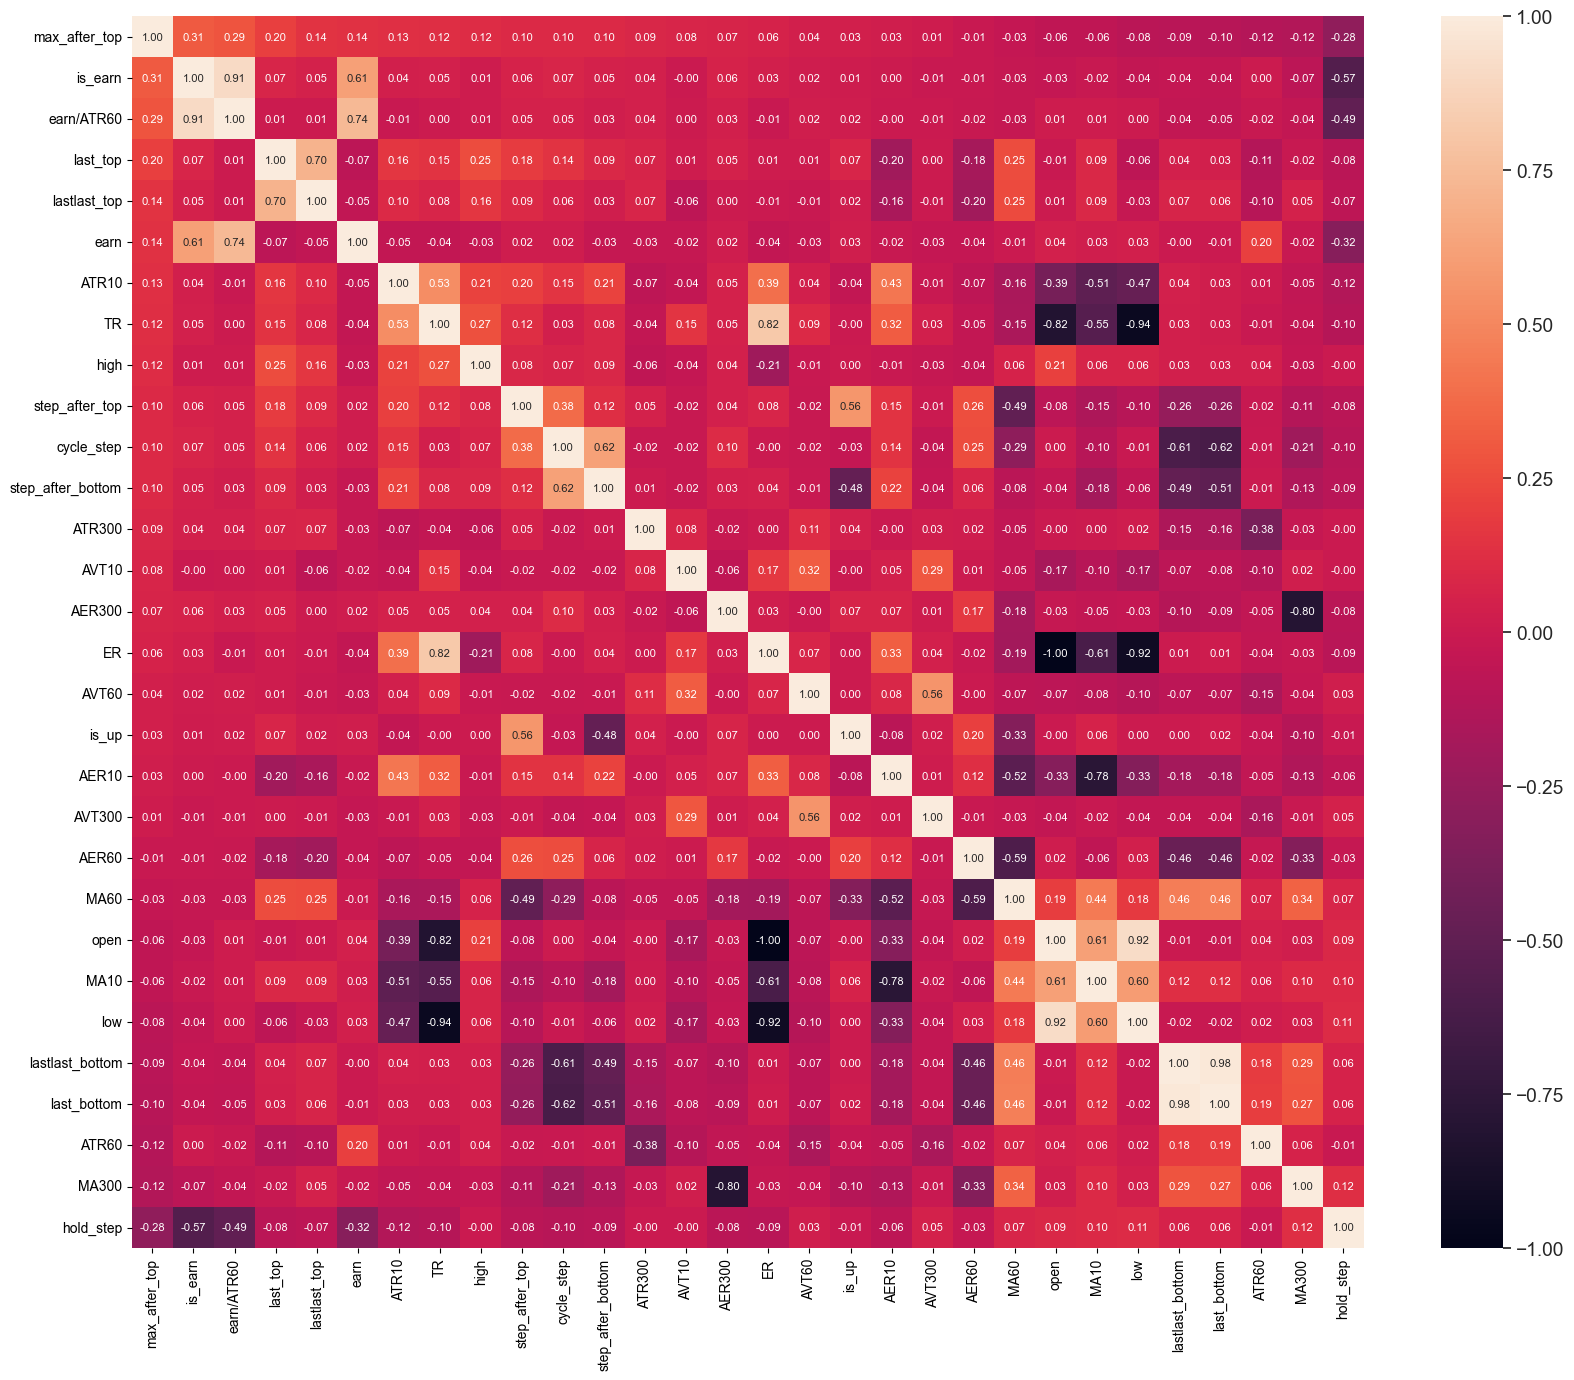

In [6]:
heatmap_data = full_data.df.iloc[:, :].copy()

target_name = target.target_name()
target.drop_others(heatmap_data)
drop_col(heatmap_data, [target.target_name()])

heatmap_data['earn/ATR60'] = heatmap_data['earn'] / heatmap_data['ATR60']
heatmap_data['max_after_top'] = heatmap_data['max_after_top'] / heatmap_data['ATR60']

for feat in price_feats:
    heatmap_data[feat] = (heatmap_data[feat] - 1) / heatmap_data['ATR60']

for feat in dprice_feats:
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data['ATR60']

# heatmap_data['ATR10-60'] = heatmap_data['ATR10'] / heatmap_data['ATR60']
for feat in (tr_feats - {'ATR60'}):
    heatmap_data[feat] = heatmap_data[feat] / heatmap_data['ATR60']

# for feat in (vol_feats - {'AQAV60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AQAV60']

# for feat in (voltr_feats - {'AVT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AVT60']
    
# for feat in (tn_feats - {'AT60'}):
#     heatmap_data[feat] = heatmap_data[feat] / heatmap_data['AT60']


heatmap_data.replace([np.inf, -np.inf], np.nan, inplace=True)
heatmap_data.dropna(axis=0, how='any', inplace=True)

# drop_col(heatmap_data, price_feats - {max_100, min_100})
# drop_col(heatmap_data, dprice_feats)
# drop_col(heatmap_data, tr_feats)
drop_col(heatmap_data, tn_feats)
# drop_col(heatmap_data, vol_feats)
# drop_col(heatmap_data, set(full_data.cols_of_features([FeatTypes.OTHERS])))


target_name = 'max_after_top'
max_loss_idx = heatmap_data[heatmap_data['earn/ATR60'] < -0.5001].index
print(len(max_loss_idx))

heatmap_font(heatmap_data.iloc[:, :].loc[:, :], target=target_name)

up_idx = heatmap_data[heatmap_data['is_up'] == 1].index
down_idx = heatmap_data[heatmap_data['is_up'] == 0].index
drop_col(heatmap_data, ['is_up'])

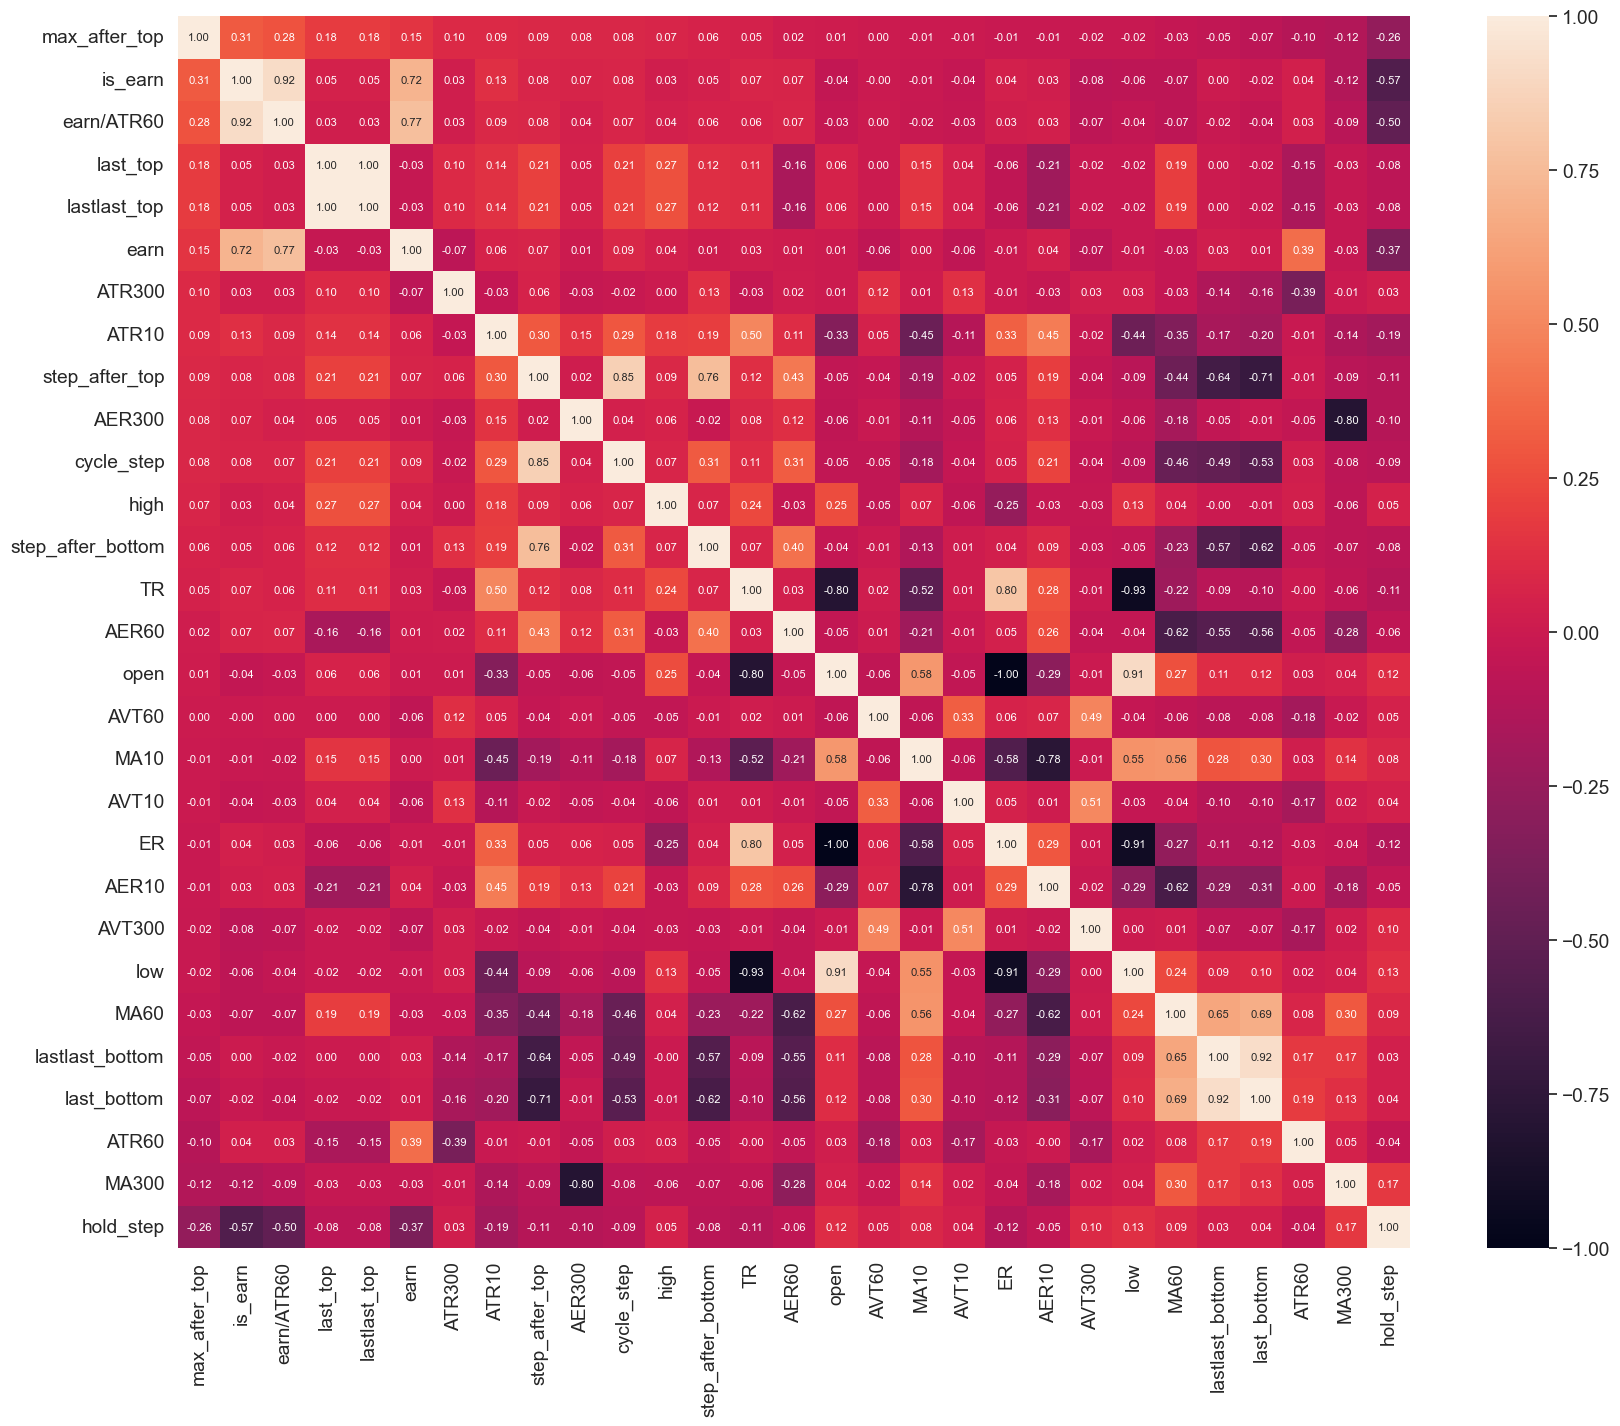

In [7]:
# up_loss_idx = [idx for idx in max_loss_idx if idx in up_idx]
# print(len(up_loss_idx))
heatmap_font(heatmap_data.loc[up_idx, :], target=target_name)
# heatmap_data.loc[up_loss_idx].head()

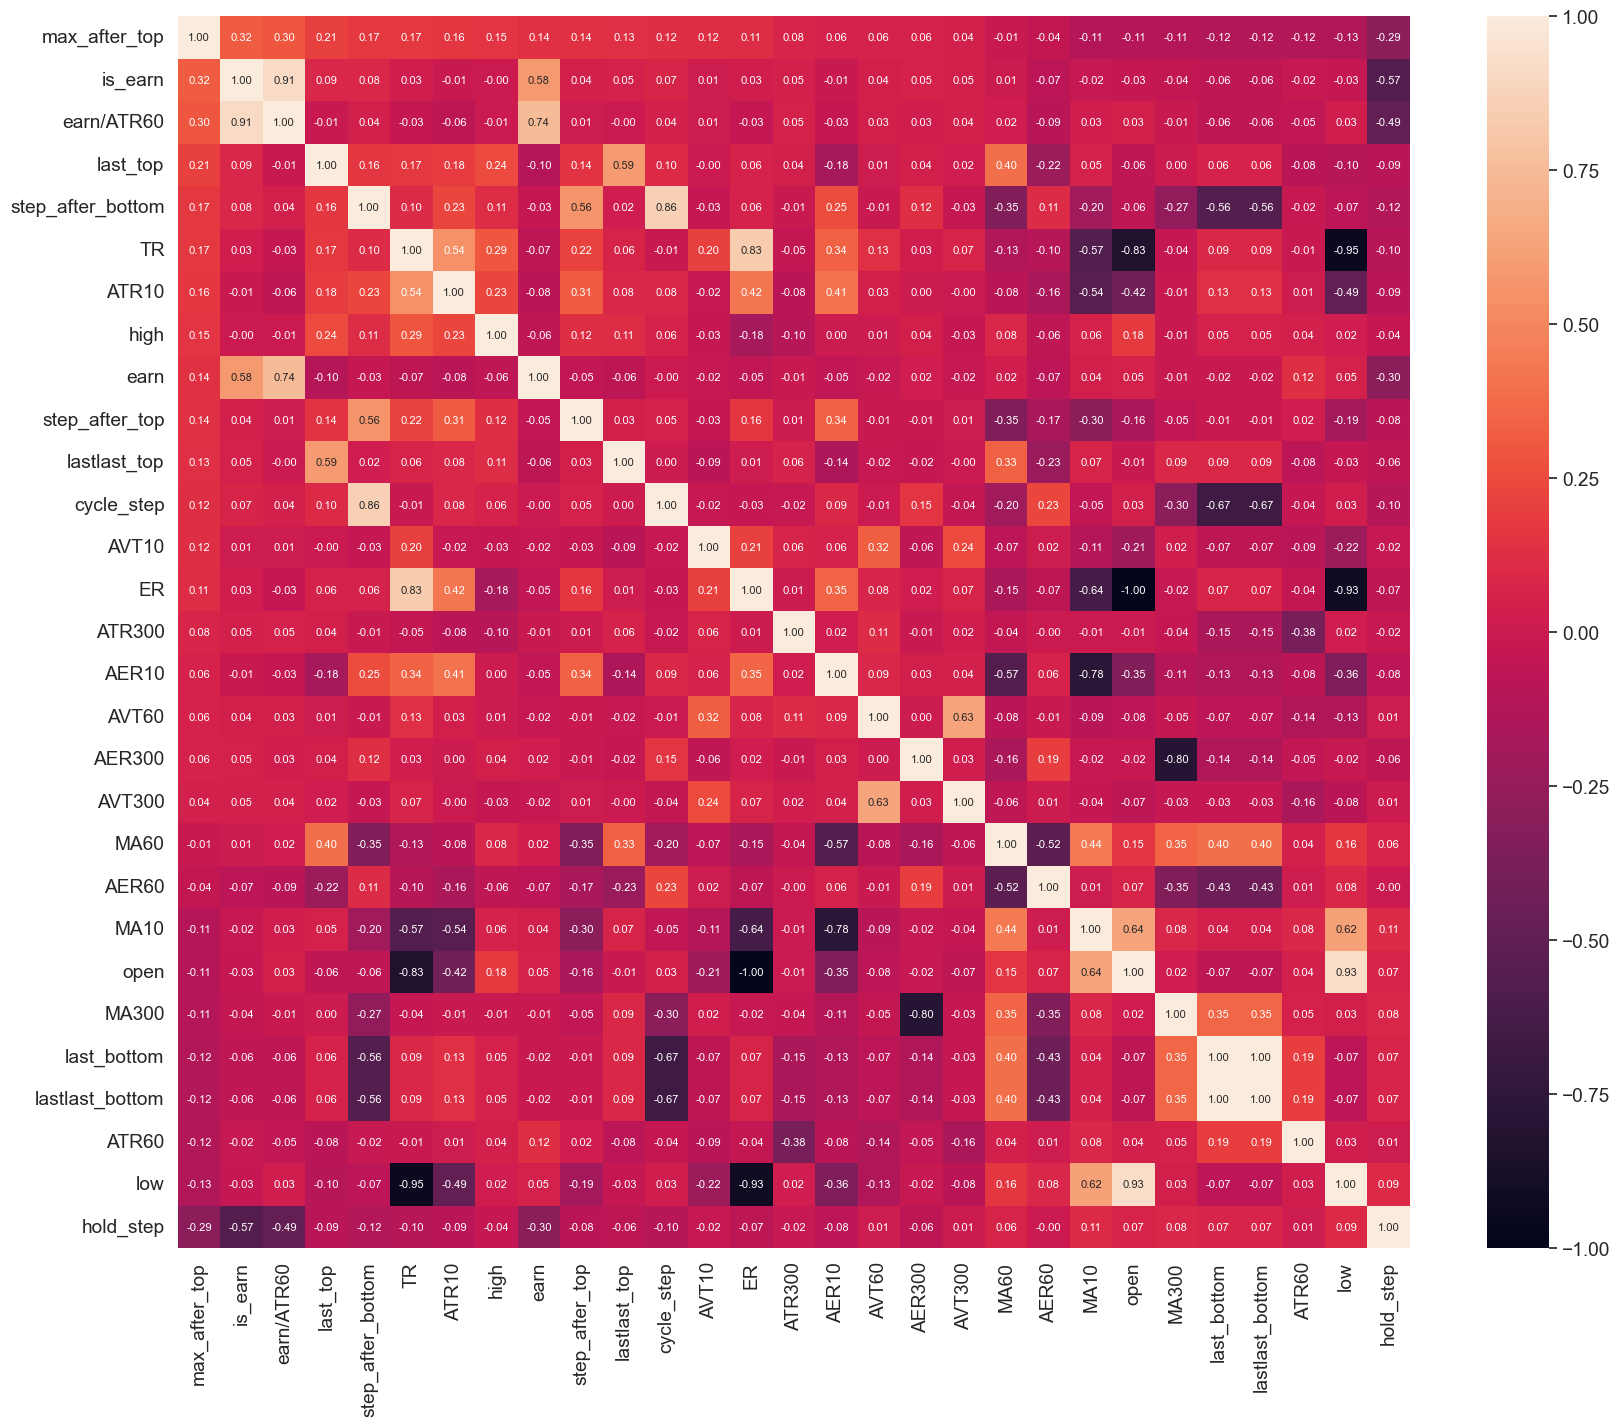

In [8]:
# down_loss_idx = [idx for idx in max_loss_idx if idx in down_idx]
# print(len(down_loss_idx))
heatmap_font(heatmap_data.loc[down_idx, :], target=target_name)
# heatmap_data.loc[down_loss_idx].head()

In [9]:
full_data.df.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,is_up,cycle_step,hold_step,earn,earn_after_10,is_earn,max_after_top,ER,lastlast_top,lastlast_bottom,MA10,MA60,MA300,ATR10,ATR60,ATR300,AVT10,AVT60,AVT300,AER10,AER60,AER300
312,0.999838,1.000056,0.998913,0.001143,1.000146,36.0,0.992381,56.0,0.0,20.0,0.0,0.000811,0.001583,1,0.001350,0.000162,1.000146,0.992381,0.997541,0.997487,0.987523,0.001225,0.001622,0.001654,0.593612,0.910740,1.004337,0.000345,-0.000096,5.723525e-05
404,1.000224,1.000436,0.999748,0.000688,1.000758,64.0,0.988067,106.0,0.0,42.0,0.0,0.000473,0.002681,1,0.004034,-0.000224,1.000758,0.988067,0.999246,0.997159,0.989377,0.000871,0.000946,0.001579,0.836712,0.793304,1.172480,0.000146,0.000025,9.220909e-05
581,0.998862,1.000000,0.998862,0.001138,1.001052,70.0,0.998672,78.0,0.0,8.0,0.0,0.000220,0.000035,1,0.000445,0.001138,1.001052,0.998672,0.999033,0.999194,1.000433,0.000228,0.000441,0.000846,5.347997,1.848135,1.293108,0.000088,0.000010,2.367959e-05
665,0.999088,1.000236,0.999085,0.001150,1.000362,60.0,0.994068,107.0,0.0,47.0,0.0,0.000352,-0.002023,1,0.001444,0.000912,1.000362,0.994068,0.999123,0.997837,0.997590,0.000955,0.000704,0.000734,2.110453,2.429820,2.967390,0.000130,0.000010,1.789012e-05
781,0.999712,1.000000,0.999667,0.000333,1.000237,33.0,0.997085,49.0,0.0,16.0,1.0,-0.000265,-0.001071,0,0.000049,0.000288,1.000237,0.997085,0.999067,0.998590,1.000377,0.000433,0.000531,0.000605,1.473388,1.174887,1.794641,0.000148,-0.000018,-7.786191e-06
901,0.999517,1.000000,0.999517,0.000483,1.000115,119.0,0.994099,81.0,1.0,38.0,0.0,0.000175,-0.001047,1,0.000478,0.000483,1.000115,0.994099,0.998341,0.997642,0.999146,0.000341,0.000349,0.000563,57.952137,11.583738,3.324856,0.000228,0.000063,-1.312573e-05
992,0.999653,1.000000,0.999632,0.000368,1.000515,90.0,0.995479,63.0,1.0,27.0,1.0,-0.000185,0.000347,0,0.000042,0.000347,1.000515,0.995479,0.999462,0.998537,0.998035,0.000280,0.000370,0.000459,2.485671,4.354057,7.450759,0.000056,0.000056,-1.381960e-06
1042,0.999578,1.000047,0.999304,0.000743,1.001340,42.0,0.995437,113.0,0.0,71.0,0.0,0.000203,0.000672,1,0.002530,0.000422,1.001340,0.995437,0.998877,0.999693,0.998126,0.000339,0.000405,0.000426,1.017296,1.614341,3.381985,0.000101,0.000007,6.323955e-07
1142,0.999986,1.000002,0.999984,0.000019,1.000324,30.0,0.996478,51.0,0.0,21.0,0.0,0.000244,0.000474,1,0.000420,0.000014,1.005752,0.996478,0.999062,0.998385,1.000100,0.000485,0.000487,0.000443,0.143712,0.102332,0.247470,0.000131,0.000036,6.054220e-06
1203,0.999895,1.000103,0.999808,0.000295,1.000431,48.0,0.996042,68.0,0.0,20.0,0.0,0.000271,0.002618,1,0.000696,0.000105,1.000431,0.996042,0.999763,0.998960,0.998927,0.000638,0.000542,0.000480,0.565894,0.437392,0.661694,0.000246,0.000019,-3.968291e-06


In [10]:
heatmap_data.head(10)

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,ER,lastlast_top,lastlast_bottom,MA10,MA60,MA300,ATR10,ATR60,ATR300,AVT10,AVT60,AVT300,AER10,AER60,AER300,earn/ATR60
312,-0.099897,0.034747,-0.670325,0.705086,0.089763,36.0,-4.698064,56.0,20.0,0.0,0.000811,1,0.832477,0.099897,0.089763,-4.698064,-1.516266,-1.549806,-7.693320,0.755614,0.001622,1.020066,0.593612,0.910740,1.004337,0.212680,-0.059166,0.035292,0.499993
404,0.236700,0.461072,-0.266288,0.727384,0.801328,64.0,-12.609207,106.0,42.0,0.0,0.000473,1,4.263066,-0.236700,0.801328,-12.609207,-0.796397,-3.002433,-11.224446,0.920689,0.000946,1.668595,0.836712,0.793304,1.172480,0.154595,0.025930,0.097433,0.499988
581,-2.584053,0.000000,-2.584053,2.584106,2.387324,70.0,-3.014728,78.0,8.0,0.0,0.000220,1,1.010226,2.584053,2.387324,-3.014728,-2.194850,-1.830725,0.983553,0.517927,0.000441,1.920210,5.347997,1.848135,1.293108,0.200450,0.023395,0.053755,0.499973
665,-1.296663,0.334944,-1.299979,1.634956,0.514022,60.0,-8.429966,107.0,47.0,0.0,0.000352,1,2.052773,1.296663,0.514022,-8.429966,-1.245924,-3.073853,-3.425091,1.357052,0.000704,1.042990,2.110453,2.429820,2.967390,0.184716,0.014315,0.025425,0.499983
781,-0.543142,0.000000,-0.627042,0.627086,0.445995,33.0,-5.493244,49.0,16.0,1.0,-0.000265,0,0.092732,0.543142,0.445995,-5.493244,-1.758368,-2.656687,0.710000,0.816082,0.000531,1.140746,1.473388,1.174887,1.794641,0.278195,-0.033045,-0.014675,-0.499978
901,-1.381685,0.000000,-1.381685,1.381752,0.328653,119.0,-16.895457,81.0,38.0,0.0,0.000175,1,1.368270,1.381685,0.328653,-16.895457,-4.750045,-6.751476,-2.443883,0.976637,0.000349,1.613397,57.952137,11.583738,3.324856,0.651941,0.180536,-0.037583,0.499966
992,-0.935959,0.000000,-0.992875,0.992938,1.391290,90.0,-12.205405,63.0,27.0,1.0,-0.000185,0,0.113833,0.935959,1.391290,-12.205405,-1.453265,-3.950314,-5.306421,0.756419,0.000370,1.239028,2.485671,4.354057,7.450759,0.151777,0.150828,-0.003731,-0.499968
1042,-1.040002,0.115556,-1.716003,1.831616,3.304894,42.0,-11.255128,113.0,71.0,0.0,0.000203,1,6.240009,1.040002,3.304894,-11.255128,-2.771026,-0.758142,-4.621632,0.835526,0.000405,1.051576,1.017296,1.614341,3.381985,0.248445,0.018007,0.001560,0.499971
1142,-0.028893,0.004816,-0.033709,0.038573,0.664548,30.0,-7.228161,51.0,21.0,0.0,0.000244,1,0.861986,0.028893,11.802947,-7.228161,-1.925744,-3.313830,0.204196,0.995425,0.000487,0.908135,0.143712,0.102332,0.247470,0.269672,0.074320,0.012424,0.499976
1203,-0.194698,0.190372,-0.354784,0.545199,0.796100,48.0,-7.307681,68.0,20.0,0.0,0.000271,1,1.285010,0.194698,0.796100,-7.307681,-0.437855,-1.920015,-1.981641,1.177320,0.000542,0.886238,0.565894,0.437392,0.661694,0.453864,0.035478,-0.007326,0.499978


In [11]:
temp = heatmap_data[(heatmap_data['ATR60'] > 0.0) & (heatmap_data['ATR60'] <= 0.000334)]
print(len(temp))
# histplot(temp['max_after_top'])
for delta in np.arange(0.2, 1.5, 0.1): 
    earn_rate = sum(temp['max_after_top'] > delta) / len(temp)
    print(f"{delta :.1f}:  rate: {earn_rate*100 :.2f}%, ave earn: {2 * delta * (earn_rate - 0.5):.5f}")

171
0.2:  rate: 88.30%, ave earn: 0.15322
0.3:  rate: 82.46%, ave earn: 0.19474
0.4:  rate: 77.78%, ave earn: 0.22222
0.5:  rate: 75.44%, ave earn: 0.25439
0.6:  rate: 73.68%, ave earn: 0.28421
0.7:  rate: 71.35%, ave earn: 0.29883
0.8:  rate: 69.59%, ave earn: 0.31345
0.9:  rate: 67.25%, ave earn: 0.31053
1.0:  rate: 66.67%, ave earn: 0.33333
1.1:  rate: 64.33%, ave earn: 0.31520
1.2:  rate: 61.40%, ave earn: 0.27368
1.3:  rate: 59.06%, ave earn: 0.23567
1.4:  rate: 56.73%, ave earn: 0.18830


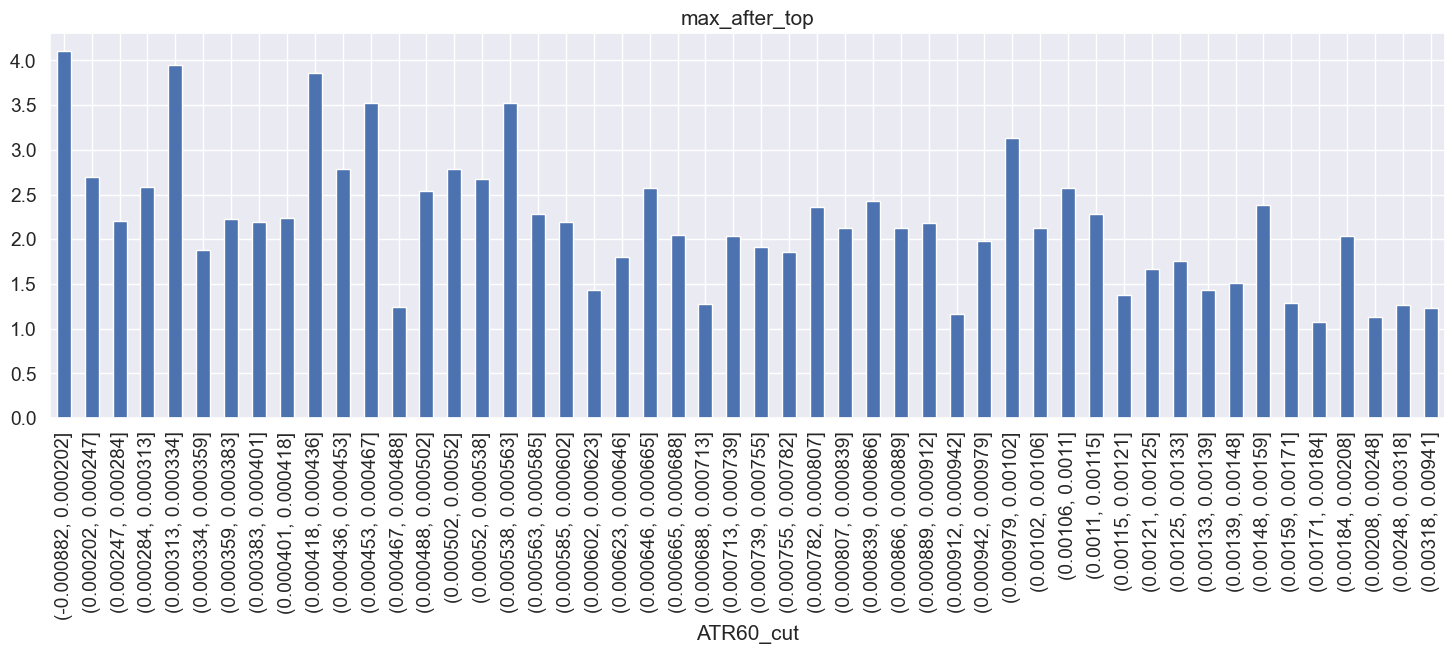

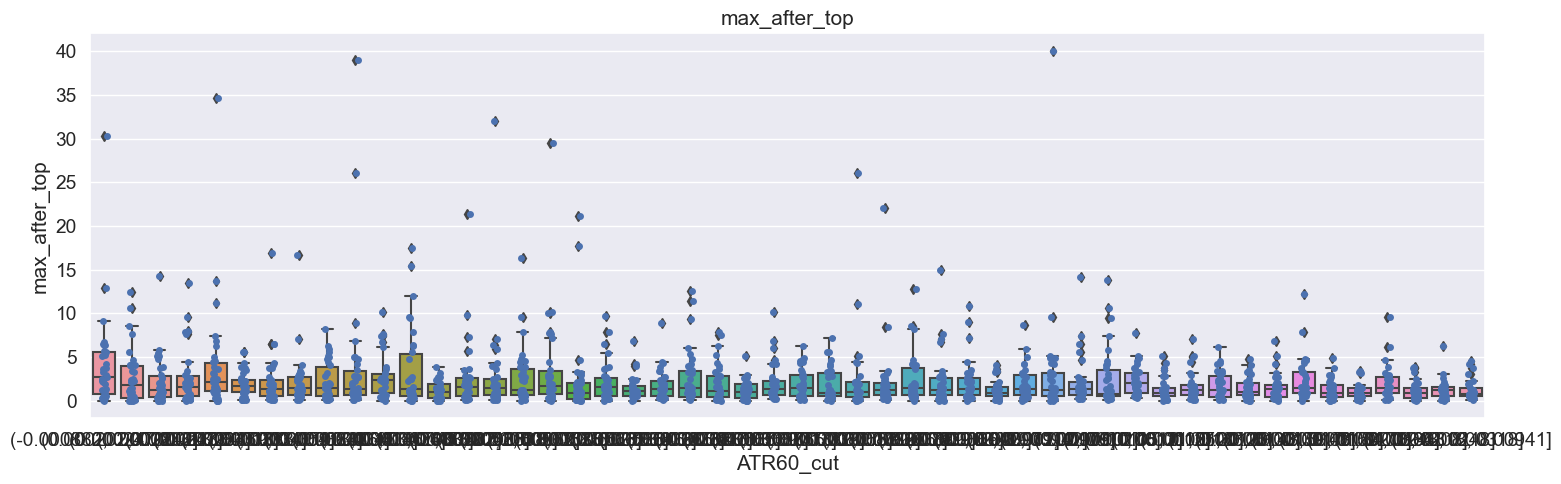

In [14]:

plot_data = heatmap_data.loc[:, :].copy()
plot_data['index'] = plot_data.index
checked = 'ATR60'
bias = 0

# plt_A_B(plot_data, 'index', 'earn/ATR60', cut_num=10)
# plt_box_A_B(plot_data, 'index', 'earn/ATR60', cut_num=10)
# plt_A_B(plot_data, 'index', 'ATR10', cut_num=10)

# plt_A_B(plot_data, 'index', checked, cut_num=10, bias=bias)
# plt_box_A_B(plot_data, 'index', checked, cut_num=10)

plt_A_B(plot_data, checked, target_name, cut_num=50)
plt_box_A_B(plot_data, checked, target_name, cut_num=50)

In [29]:
heatmap_data[heatmap_data['ATR60'] <= 0.00015]

,open,high,low,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,max_after_top,ER,lastlast_top,lastlast_bottom,MA10,MA60,MA300,ATR10,ATR60,ATR300,AVT10,AVT60,AVT300,AER10,AER60,AER300,earn/ATR60
106892,-1.027611,0.000000,-1.027611,1.027766,2.522317,70.0,-7.582520,33.0,37.0,0.0,0.000072,1,2.475607,1.027611,2.522317,-7.582520,-4.017023,-4.015985,-18.819701,1.069805,0.000145,1.696595,13.815236,8.605479,5.461470,0.653934,0.047488,0.093004,0.499922
107594,0.016364,0.016364,0.000000,0.016528,2.241859,47.0,-23.236786,101.0,54.0,0.0,0.000068,1,2.340043,-0.016364,2.241859,-23.236786,-1.245295,-4.105438,-2.349152,0.909998,0.000137,2.111384,0.741810,0.875828,0.433102,0.620193,0.135002,-0.000491,0.499918
107689,-1.452824,0.081619,-1.469148,1.550930,1.485472,33.0,-10.479922,53.0,20.0,0.0,0.000068,1,3.787137,1.452824,1.485472,-10.479922,-2.595495,-4.909675,-7.671509,0.764120,0.000137,1.415823,4.157407,3.216373,4.126496,0.432582,0.163783,0.024976,0.499918
127692,-1.901241,0.000000,-1.901241,1.901439,3.485609,49.0,-5.881965,71.0,22.0,0.0,0.000059,1,3.247954,1.901241,3.485609,-5.881965,-1.889358,-3.003697,-4.108463,1.136982,0.000118,1.616055,4.298534,10.316090,9.540035,0.065355,0.054793,0.059018,0.499901
137264,-1.370893,0.017353,-1.370893,1.388420,0.069412,71.0,-8.051828,38.0,33.0,0.0,0.000072,1,30.333179,1.370893,0.069412,-8.051828,-2.682786,-4.070743,-10.959452,0.843533,0.000143,1.874942,2.264706,4.341442,3.892271,0.119736,0.091971,0.054778,0.499913
137806,0.000000,0.000000,-0.019020,0.019210,1.274330,95.0,-13.884486,43.0,52.0,0.0,0.000065,1,6.714005,0.000000,1.274330,-13.884486,-1.913396,-6.917834,-7.222913,1.179421,0.000130,1.658023,0.888337,0.853692,1.425514,0.319533,0.158499,-0.053192,0.499905
138151,0.288799,0.288799,0.000000,0.289005,7.508767,73.0,-1.443994,113.0,40.0,0.0,0.000060,1,6.332944,-0.288799,7.508767,-1.443994,-1.384171,-3.781201,-7.794403,1.087327,0.000120,1.417177,3.210041,8.759529,4.196120,0.309427,-0.032318,0.036994,0.499897
163656,-0.140722,0.000000,-0.140722,0.140923,2.955170,54.0,-7.176841,68.0,14.0,0.0,0.000063,1,3.638679,0.140722,2.955170,-7.176841,-2.331971,-2.363801,-5.871876,0.547008,0.000125,2.215573,4.524538,5.651880,6.633185,0.532735,0.063325,0.066609,0.499899
208213,-0.693214,0.023107,-0.693214,0.716552,0.924286,53.0,-25.348533,80.0,27.0,0.0,0.000073,1,5.268428,0.693214,0.924286,-25.348533,-3.124085,-2.507895,-0.711315,0.954556,0.000145,2.043981,3.082724,2.552508,1.228862,0.323500,0.047370,-0.101209,0.499884


In [35]:
# heatmap_data['ATR10'].mean()
heatmap_data['AER10'].mean()

0.25180949334818037

In [30]:
get_sell_atr = lambda x: 1 - (x - 0.000260) / (0.00228 - 0.000260) * 0.5
get_sell_atr(0.000130)

1.0321782178217822

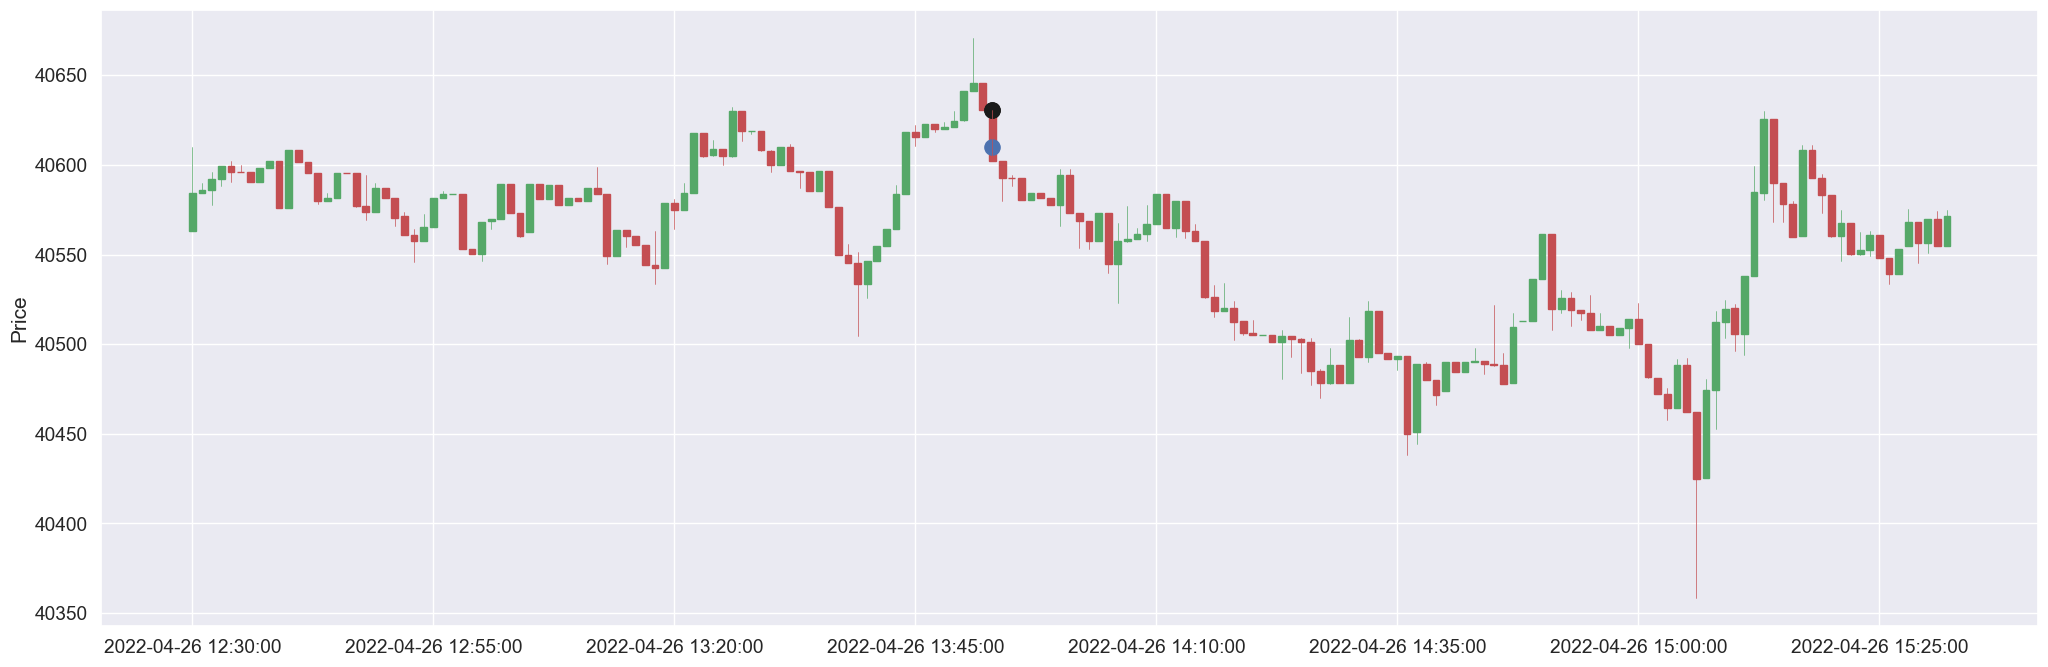

In [13]:
# idx = heatmap_data[(heatmap_data['high'] > 0.4)].index
# print(len(idx))
# 150765 有问题！！！
start = 150765      
# print(f"high: {heatmap_data.loc[start, 'earn/ATR60']}")
last_top_idx = start - sim_data.loc[start, 'step_after_top']
sell_idx = sim_data.loc[start, 'hold_step'] + start + 1
points = [PricePlot.Points(start+1, sim_data.loc[start, 'last_top'], s=120, c='b', label='default'),
          PricePlot.Points(sell_idx, sim_data.loc[start, 'sell_price'], s=120, c='k', label='default'),
          PricePlot.Points(start+1, sim_data.loc[start, 'buy_price'], s=120, c='k', label='default')]
plot(sim_data, last_top_idx, start+100, points)

In [81]:
heatmap_data[heatmap_data.index > 100000]

,open,high,low,taker_buy_quote_asset_volume,TR,last_top,step_after_top,last_bottom,step_after_bottom,cycle_step,hold_step,earn,is_earn,lastlast_top,lastlast_bottom,MA10,MA60,MA300,ATR10,ATR60,ATR300,AVT10,AVT60,AVT300,MACD_close,signal_close,histogram_close,MACD_TR,signal_TR,histogram_TR,earn/ATR300
100064,1.000212,1.000212,0.999937,6.252929e+04,0.000275,1.001008,62.0,0.997545,81.0,19.0,4.0,0.001538,1,1.001008,0.997545,0.999954,0.998413,1.001782,0.000442,0.000503,0.000513,1.636423,1.579100,1.680561,0.000952,0.000459,0.000492,-0.000101,-0.000052,-0.000049,3.0
100134,1.000039,1.000070,1.000000,1.954607e+04,0.000070,1.000921,48.0,0.997261,31.0,17.0,0.0,0.001528,1,1.000921,0.997261,1.000157,0.999322,0.999300,0.000264,0.000419,0.000509,0.501929,0.861836,0.876971,0.000897,0.000831,0.000066,-0.000122,-0.000101,-0.000021,3.0
100278,0.999418,1.000000,0.999418,2.448667e+05,0.000582,1.001907,64.0,0.967159,175.0,111.0,0.0,0.002684,1,1.001907,0.967159,0.999107,0.997208,0.979136,0.000859,0.000804,0.000895,1.283647,1.668078,1.976637,0.002560,0.002416,0.000144,-0.000133,-0.000056,-0.000077,3.0
100503,0.998735,1.000177,0.998588,7.473153e+05,0.001589,1.000382,52.0,0.995551,45.0,7.0,35.0,0.003593,1,1.000382,0.995551,0.997111,0.997463,1.003213,0.001437,0.000839,0.001198,0.983582,1.163276,1.153318,0.000399,-0.000396,0.000795,0.000257,0.000212,0.000046,3.0
100636,0.999566,1.000415,0.999566,1.016625e+06,0.000849,1.000978,95.0,0.994140,53.0,42.0,9.0,0.002767,1,1.000978,0.994140,0.998991,0.996671,0.995410,0.000497,0.000522,0.000922,0.608457,0.369140,0.443616,0.001902,0.001361,0.000541,-0.000015,-0.000033,0.000018,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271566,1.000077,1.000985,0.999797,2.901118e+05,0.001189,1.001320,44.0,0.990812,68.0,24.0,33.0,-0.006974,0,1.001320,0.990812,0.999586,0.998185,1.000439,0.001066,0.001292,0.002325,1.559421,1.624031,2.015685,0.000955,0.000239,0.000716,-0.000320,-0.000292,-0.000029,-3.0
271686,0.999611,1.000101,0.999606,4.433937e+05,0.000494,1.004252,33.0,0.992897,68.0,35.0,3.0,0.005882,1,1.004252,0.992897,1.000362,1.000860,1.011728,0.000965,0.001109,0.001961,0.876267,0.908762,0.969811,-0.001348,-0.001020,-0.000328,-0.000291,-0.000245,-0.000046,3.0
271759,1.000227,1.000327,0.999737,1.668583e+05,0.000590,1.002495,63.0,0.989771,75.0,12.0,14.0,-0.004550,0,1.002495,0.989771,0.998131,0.998403,0.998651,0.001157,0.001144,0.001517,1.241227,1.386118,1.458284,0.001162,-0.000221,0.001382,-0.000053,-0.000024,-0.000029,-3.0
271884,0.998535,1.000522,0.998530,5.628232e+05,0.001992,1.001163,76.0,0.992675,46.0,30.0,129.0,0.004651,1,1.001163,0.992675,0.998742,0.997079,1.002241,0.000978,0.001474,0.001550,0.894153,1.546508,2.127880,0.000854,0.000775,0.000079,-0.000259,-0.000314,0.000055,3.0
